In [1]:
%matplotlib inline
import numpy as np

from scipy.stats import linregress
from scipy.stats import gmean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn
import pandas as pd

In [2]:
# Load the data from Excel, remove data points that are not comparable.
raw_kin_df = pd.read_excel('../data/01152018rubisco_kinetics.xlsx', index_col=0)
wt_only_df = raw_kin_df[raw_kin_df.mutant == False]

# Some measurements are made at much higher temps and are not comparable.
# TODO: collect pH of measurements so we can restrict to similar range
high_T = wt_only_df.Temp_C > 30
wt_only_df = wt_only_df.loc[np.logical_not(high_T)]

# Filtered DataFrame used for most plots below.
# Only variants with all the data
kin_df = wt_only_df.copy()
has_KMs = np.logical_and(np.isfinite(kin_df.Kc), np.isfinite(kin_df.Ko))
has_kcats = np.logical_and(np.isfinite(kin_df.Vc), np.isfinite(kin_df.Vo))
has_kons = np.logical_and(np.isfinite(kin_df.kon_C), np.isfinite(kin_df.kon_O))
has_all = np.logical_and(np.logical_and(has_KMs, has_kcats), has_kons)
kin_df = kin_df[has_all]

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_df = wt_only_df[wt_only_df.savir]
nonsavir_df = wt_only_df[wt_only_df.savir == False]

# Group by RuBisCO form
grouped_form = wt_only_df.groupby('form_text')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "bluey green", "dusty red"]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
print wt_only_df.shape[0], 'total WT RuBisCOs'
print kin_df.shape[0], 'RuBisCOs with all core kinetic data measured'

158 total WT RuBisCOs
136 RuBisCOs with all core kinetic data measured


In [15]:
# Perform PCA on kin_df - the subset of the data for which we have all values.
# Here we are doing this on all the data, including all the RuBisCO isoforms
vC_vals = kin_df.Vc.values
Kc_vals = kin_df.Kc.values
S_vals = kin_df.S.values
Kc_Ko_vals = Kc_vals / kin_df.Ko.values

# Careful here: input data should have samples along rows, features along cols.
data = np.vstack([vC_vals, Kc_vals, S_vals, Kc_Ko_vals]).T
log_data = np.log(data)
scaler = StandardScaler()
normed_log_data = scaler.fit_transform(log_data)

pca = PCA(n_components=2)
fitted = pca.fit(log_data)

pca_normed = PCA()
fitted_normed = pca_normed.fit(normed_log_data)
fitted_normed.components_[0]

array([ 0.07643917,  0.53904965, -0.57203048,  0.61348484])

In [16]:
print 'PCA of all data, no normalization'
pct_variance_explained = 100*fitted.explained_variance_ratio_

print "$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0]
print "$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1]

complist = tuple(fitted.components_[0].tolist())
print 'PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

complist = tuple(fitted.components_[1].tolist())
print 'PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist


PCA of all data, no normalization
$1^{st}$ PC explains 76.0% of variance
$2^{nd}$ PC explains 14.5% of variance
PC1 0.035 *log(vC) + 0.48 *log(KC) + -0.47 *log(S) + 0.74 *log(KC/KO)
PC2 -0.67 *log(vC) + -0.6 *log(KC) + -0.42 *log(S) + 0.15 *log(KC/KO)


In [17]:
print 'PCA of all data, normalized in advance of PCA'
pct_variance_explained = 100*fitted_normed.explained_variance_ratio_

print "$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0]
print "$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1]

complist = tuple(fitted_normed.components_[0].tolist())
print 'PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

complist = tuple(fitted_normed.components_[1].tolist())
print 'PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist


PCA of all data, normalized in advance of PCA
$1^{st}$ PC explains 61.6% of variance
$2^{nd}$ PC explains 27.5% of variance
PC1 0.076 *log(vC) + 0.54 *log(KC) + -0.57 *log(S) + 0.61 *log(KC/KO)
PC2 -0.92 *log(vC) + -0.24 *log(KC) + -0.29 *log(S) + 0.058 *log(KC/KO)


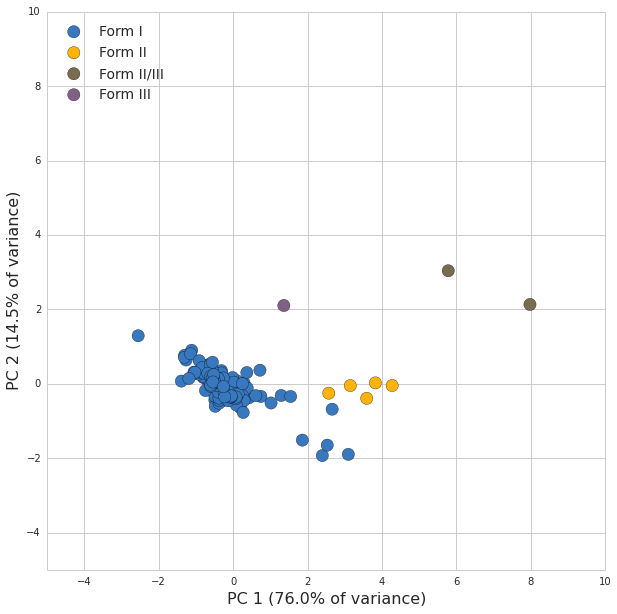

In [18]:
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

transformed = fitted.transform(log_data)
forms = sorted(kin_df.form_text.unique())
colormapping = dict((forms[i], named_colors[i]) for i in xrange(len(forms)))
colors = [colormapping[f] for f in kin_df.form_text]

for form in forms:
    idxs = np.where(kin_df.form_text == form)
    color = colormapping[form]
    l = 'Form %s' % form
    plt.scatter(transformed[idxs, 0], transformed[idxs, 1], s=150, c=color, label=l)


pct_variance_explained = 100*fitted.explained_variance_ratio_
plt.xlabel('PC 1 (%.1f%% of variance)' % pct_variance_explained[0], fontsize=16)
plt.ylabel('PC 2 (%.1f%% of variance)' % pct_variance_explained[1], fontsize=16)

plt.legend(loc=2, fontsize=14)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.show()

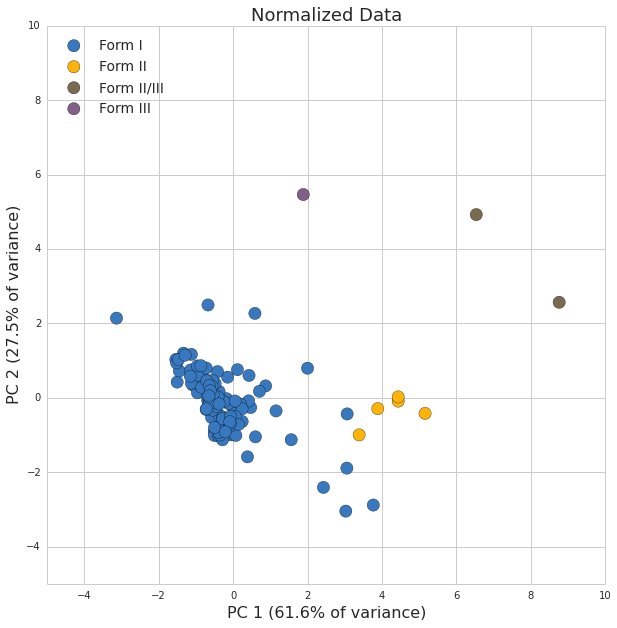

In [7]:
# Plot PCA of normalized data for all RuBisCOs
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

pcts = 100*fitted_normed.explained_variance_ratio_
transformed_normed = fitted_normed.transform(normed_log_data)
forms = sorted(kin_df.form_text.unique())
colormapping = dict((forms[i], named_colors[i]) for i in xrange(len(forms)))
colors = [colormapping[f] for f in kin_df.form_text]

for form in forms:
    idxs = np.where(kin_df.form_text == form)
    color = colormapping[form]
    l = 'Form %s' % form
    plt.scatter(transformed_normed[idxs, 0], transformed_normed[idxs, 1], s=150, c=color, label=l)

plt.xlabel('PC 1 (%.1f%% of variance)' % pcts[0], fontsize=16)
plt.ylabel('PC 2 (%.1f%% of variance)' % pcts[1], fontsize=16)

plt.legend(loc=2, fontsize=14)
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.title('Normalized Data', fontsize=18)

plt.show()

In [20]:
# Perform PCA on form I rubiscos for which we have all data.
F1s = kin_df[kin_df.form_text == 'I']
vC_vals = F1s.Vc.values
Kc_vals = F1s.Kc.values
S_vals = F1s.S.values
Kc_Ko_vals = Kc_vals / F1s.Ko.values

# Careful here: input data should have samples along rows, features along cols.
data = np.vstack([vC_vals, Kc_vals, S_vals, Kc_Ko_vals]).T
log_data = np.log(data)
scaler = StandardScaler()
normed_log_data = scaler.fit_transform(log_data)

pca = PCA(n_components=2)
fitted = pca.fit(log_data)

pct_variance_explained = 100*fitted.explained_variance_ratio_

print "$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0]
print "$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1]

complist = tuple(fitted.components_[0].tolist())
print 'PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

complist = tuple(fitted.components_[1].tolist())
print 'PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

pca_normed = PCA()
fitted_normed = pca_normed.fit(normed_log_data)
fitted_normed.components_[0]
fitted_normed.explained_variance_ratio_

$1^{st}$ PC explains 77.3% of variance
$2^{nd}$ PC explains 13.5% of variance
PC1 0.27 *log(vC) + 0.76 *log(KC) + -0.17 *log(S) + 0.58 *log(KC/KO)
PC2 -0.92 *log(vC) + 0.39 *log(KC) + 0.086 *log(S) + -0.061 *log(KC/KO)


array([ 0.67382865,  0.16544026,  0.11544491,  0.04528618])

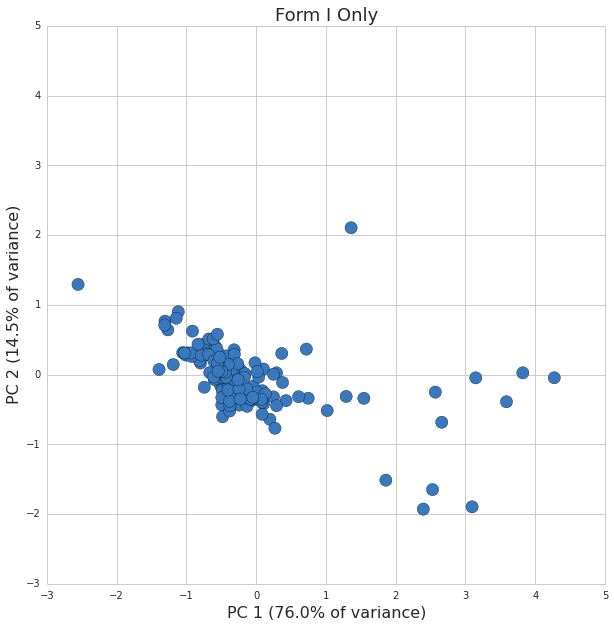

In [19]:
# Plot PCA of FI data
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

transformed = fitted.transform(log_data)

plt.scatter(transformed[:, 0], transformed[:, 1], s=150, c=named_colors[0])

plt.xlabel('PC 1 (%.1f%% of variance)' % pct_variance_explained[0], fontsize=16)
plt.ylabel('PC 2 (%.1f%% of variance)' % pct_variance_explained[1], fontsize=16)

plt.title('Form I Only', fontsize=18)
plt.xlim(-3, 5)
plt.ylim(-3, 5)

plt.show()

In [22]:
pct_variance_explained = 100*fitted_normed.explained_variance_ratio_

print "$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0]
print "$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1]

complist = tuple(fitted_normed.components_[0].tolist())
print 'PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

complist = tuple(fitted_normed.components_[1].tolist())
print 'PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

$1^{st}$ PC explains 67.4% of variance
$2^{nd}$ PC explains 16.5% of variance
PC1 0.41 *log(vC) + 0.53 *log(KC) + -0.49 *log(S) + 0.56 *log(KC/KO)
PC2 -0.9 *log(vC) + 0.37 *log(KC) + -0.1 *log(S) + 0.22 *log(KC/KO)


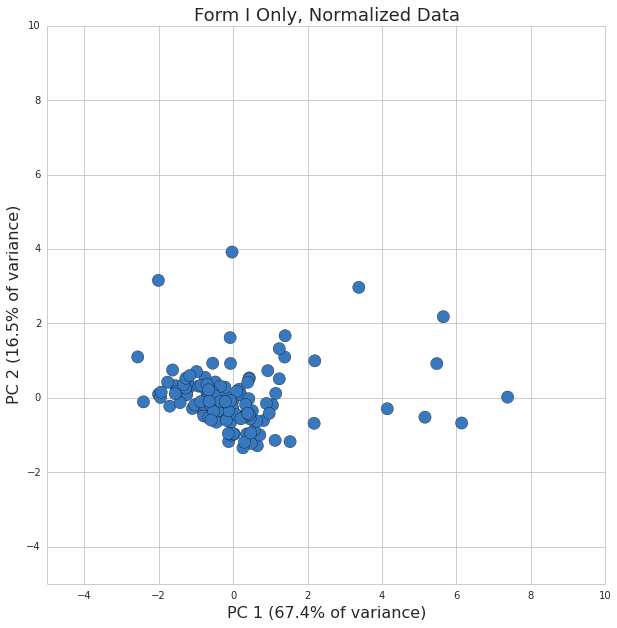

In [23]:
# Plot PCA of normalized data for FI RuBisCOs
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

pcts = 100*fitted_normed.explained_variance_ratio_
transformed_normed = fitted_normed.transform(normed_log_data)

plt.scatter(transformed_normed[:, 0], transformed_normed[:, 1], s=150, c=named_colors[0])

plt.xlabel('PC 1 (%.1f%% of variance)' % pcts[0], fontsize=16)
plt.ylabel('PC 2 (%.1f%% of variance)' % pcts[1], fontsize=16)

plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.title('Form I Only, Normalized Data', fontsize=18)
plt.show()